# DS_final Preparation – Feature Selection for XGBoost

The goal of this notebook is to refine our dataset (DS4) into a more compact and potentially better-performing version, **DS_final**, by analyzing and removing features that are either redundant or carry little predictive information.  

To achieve this, we will:  

1. Load the previously trained best **XGBoost model** and use its **feature importance scores**

2. Perform a **correlation analysis** to detect redundant variables

3. Define a set of features to remove (low importance and/or high correlation)

4. Construct and save the **DS_final dataset**, ready for retraining 

5. Evaluate if the results are better or not respect to the previous one


#### Imports and Global Settings

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

import warnings
warnings.filterwarnings("ignore")

from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import train_test_split

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Paths
DATA_DIR = "../task1_xg/data"
OUTPUT_DIR = "../task1_xg/outputs"
MODEL_DIR = "../task1_xg/models"

# Display options
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

print("Setup complete. Ready to load model & data.")

Setup complete. Ready to load model & data.


#### Load Dataset DS4 and Best Model (XGBoost)

In [ ]:
# Load dataset
ds4 = pd.read_csv(f"{DATA_DIR}/DS4.csv")
print(f"Dataset DS4 loaded: {ds4.shape[0]} rows, {ds4.shape[1]} columns")

# Drop ID columns since they are not needed for modeling
ds4 = ds4.drop(columns=['event_id', 'match_id', 'player_id'])

# Split features/target
target_col = "target_xg"
X_ds4 = ds4.drop(columns=[target_col])
y_ds4 = ds4[target_col]

print(f"Features: {X_ds4.shape[1]}, Target: '{target_col}'")


# Load pre-trained XGBoost model
xgb_model = joblib.load(f"{MODEL_DIR}/model_xgboost.pkl")
print("XGBoost model loaded successfully.")


Dataset DS4 loaded: 86833 rows, 26 columns
Features: 25, Target: 'target_xg'
XGBoost model loaded successfully.


#### Feature Importance from the model

,feature,importance
3,shot_type,0.1929
16,shot_from_set_piece,0.1922
21,num_players_between,0.1434
18,angle_to_goal,0.1258
5,shot_body_part,0.0786
17,distance_to_goal,0.0603
9,shot_one_on_one,0.0555
24,free_proj_goal,0.0270
15,end_shot_z_available,0.0190
8,shot_first_time,0.0151


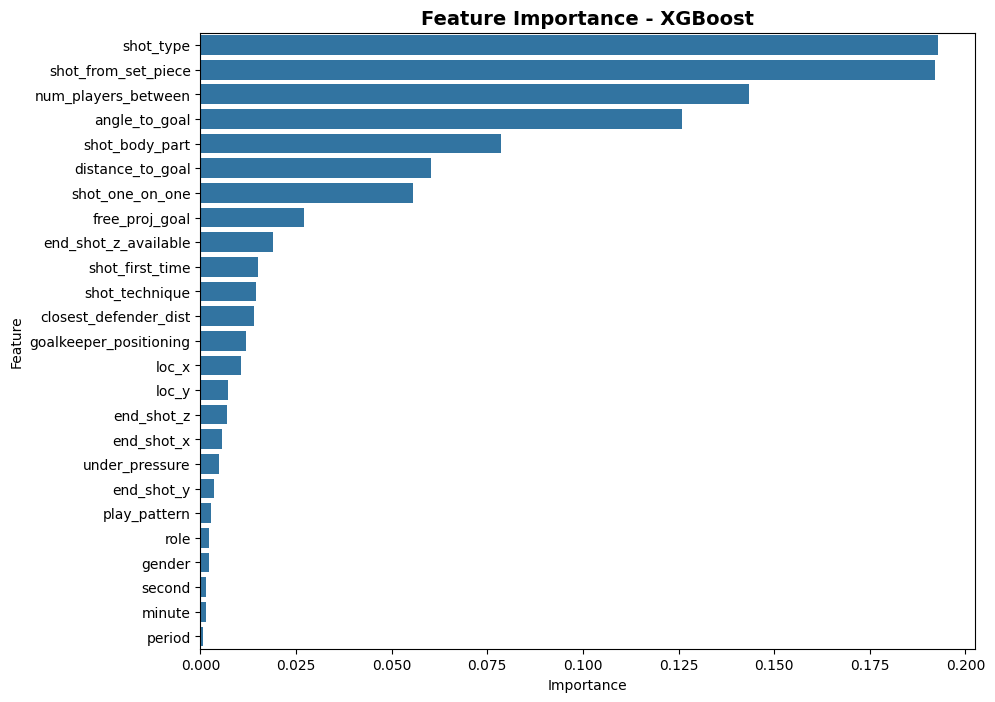

In [3]:
# Extract feature importances
importances = xgb_model.feature_importances_

# Build DataFrame
feat_imp_df = pd.DataFrame({
    "feature": X_ds4.columns,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Show top features
display(feat_imp_df)

# Plot feature importance (all features)
plt.figure(figsize=(10, 8))
sns.barplot(data=feat_imp_df, x="importance", y="feature")
plt.title("Feature Importance - XGBoost", fontsize=14, fontweight="bold")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


#### Feature Correlation Analysis

In [4]:
# Highly correlated feature pairs (|corr| > 0.5)
corr_matrix = X_ds4.corr().abs()

# Consider only upper triangle (avoid duplicates & self-correlation)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Select pairs with correlation > 0.5
high_corr_pairs = (
    upper.stack()
    .reset_index()
    .rename(columns={"level_0": "Feature_1", "level_1": "Feature_2", 0: "Correlation"})
    .sort_values(by="Correlation", ascending=False)
)

# Keep only those above threshold
high_corr_pairs = high_corr_pairs[high_corr_pairs["Correlation"] > 0.75]

display(high_corr_pairs.style.background_gradient(
    cmap="coolwarm", subset=["Correlation"]
).format({"Correlation": "{:.3f}"}))


,Feature_1,Feature_2,Correlation
81,shot_type,shot_from_set_piece,0.953
201,loc_x,distance_to_goal,0.937
224,end_shot_x,end_shot_z_available,0.787


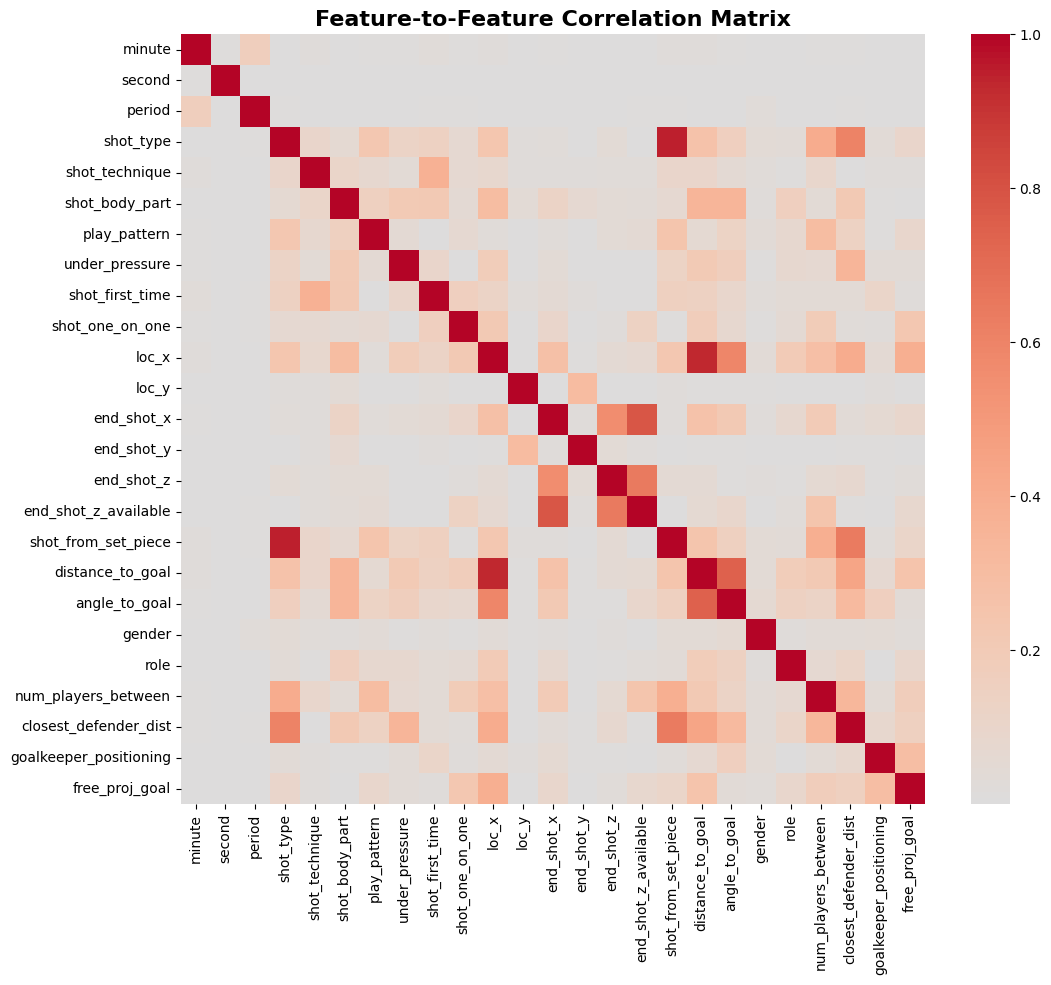

In [5]:
# Correlation matrix between features
plt.figure(figsize=(12, 10))

sns.heatmap(
    corr_matrix, 
    cmap="coolwarm", 
    center=0, 
    cbar=True
)
plt.title("Feature-to-Feature Correlation Matrix", fontsize=16, fontweight="bold")
plt.show()

In [6]:
# Correlation between features and target (xG)
target_corr = pd.DataFrame({
    "feature": X_ds4.columns,
    "correlation_with_xG": X_ds4.corrwith(y_ds4)
}).sort_values(by="correlation_with_xG", ascending=False).reset_index(drop=True)

# Tabular ranking of feature correlations with target
display(target_corr.style.background_gradient(cmap="coolwarm", subset=["correlation_with_xG"]
).format({"correlation_with_xG": "{:.3f}"}))


,feature,correlation_with_xG
0,angle_to_goal,0.673
1,loc_x,0.464
2,goalkeeper_positioning,0.279
3,shot_one_on_one,0.270
4,end_shot_x,0.203
5,end_shot_z_available,0.187
6,shot_first_time,0.173
7,shot_type,0.126
8,minute,0.030
9,loc_y,0.008


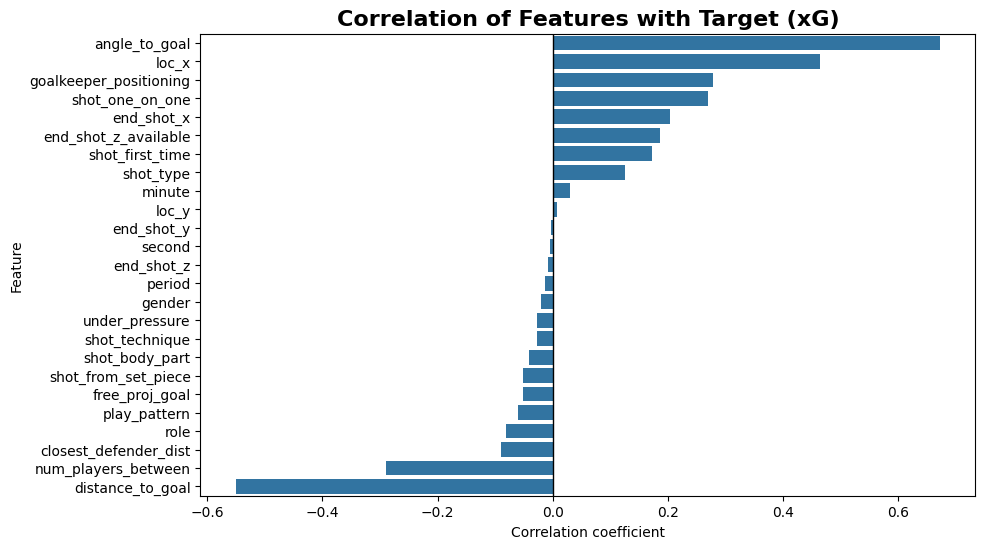

In [7]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=target_corr, 
    x="correlation_with_xG", 
    y="feature", 
)
plt.axvline(0, color="black", linewidth=1)
plt.title("Correlation of Features with Target (xG)", fontsize=16, fontweight="bold")
plt.xlabel("Correlation coefficient")
plt.ylabel("Feature")
plt.show()


#### Construction of DS_final

In [8]:
from sklearn.model_selection import train_test_split

# Features to keep
features_to_remove = [
    "minute",
    "period"
]

# Build DS_final
X_final = X_ds4.drop(columns=features_to_remove).copy()
y_final = y_ds4.copy()

# Train/test split (same seed for reproducibility)
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_final, y_final, test_size=0.2, random_state=RANDOM_STATE
)

print("DS_final created successfully.")
print("Original number of features:", X_ds4.shape[1])
print("Number of features in DS_final:", X_final.shape[1])
print("\nFeatures kept:", X_final.columns.tolist())

DS_final created successfully.
Original number of features: 25
Number of features in DS_final: 23

Features kept: ['second', 'shot_type', 'shot_technique', 'shot_body_part', 'play_pattern', 'under_pressure', 'shot_first_time', 'shot_one_on_one', 'loc_x', 'loc_y', 'end_shot_x', 'end_shot_y', 'end_shot_z', 'end_shot_z_available', 'shot_from_set_piece', 'distance_to_goal', 'angle_to_goal', 'gender', 'role', 'num_players_between', 'closest_defender_dist', 'goalkeeper_positioning', 'free_proj_goal']


#### Training and Evaluation of XGBoost on DS_final

In [9]:


def evaluate_predictions(y_true, y_pred, model_name="Model"):
    """
    Evaluate regression performance using a set of metrics
    suitable for probabilistic xG estimation (continuous target in [0, 1]).

    Parameters
    ----------
    y_true : array-like
        Ground truth (true xG values).
    y_pred : array-like
        Predicted xG values.
    model_name : str
        Label to display in output.

    Returns
    -------
    metrics : dict
        Dictionary of metric values.
    """

    metrics = {
        # Root Mean Squared Error (RMSE):
        # sqrt( (1/n) * Σ (y_i - ŷ_i)^2 )
        # Penalizes large errors more strongly; same units as target.
        "RMSE": root_mean_squared_error(y_true, y_pred),

        # Mean Absolute Error (MAE):
        # (1/n) * Σ |y_i - ŷ_i|
        # Robust to outliers; easy to interpret as "average absolute error".
        "MAE": mean_absolute_error(y_true, y_pred),

        # Coefficient of Determination (R²):
        # 1 - (Σ (y_i - ŷ_i)^2) / (Σ (y_i - ȳ)^2)
        # Measures proportion of variance explained by the model.
        "R2": r2_score(y_true, y_pred),

        # Pearson Correlation Coefficient:
        # cov(y, ŷ) / (σ_y * σ_ŷ)
        # Measures strength of linear relationship between y_true and y_pred.
        "Pearson": pearsonr(y_true, y_pred)[0],

        # Spearman Rank Correlation:
        # Pearson correlation between rank(y) and rank(ŷ)
        # Captures monotonic (not necessarily linear) relationships.
        "Spearman": spearmanr(y_true, y_pred)[0]
    }

    # Print nicely formatted results
    print(f"\n{model_name} performance:")
    for k, v in metrics.items():
        print(f"{k:>12}: {v:.4f}")

    return metrics


In [10]:
from xgboost import XGBRegressor
import joblib

# Best parameters found previously
best_params = {
    "subsample": 0.6,
    "reg_lambda": 2.0,
    "reg_alpha": 0.1,
    "n_estimators": 500,
    "max_depth": 10,
    "learning_rate": 0.01,
    "colsample_bytree": 0.8,
    "random_state": RANDOM_STATE,
    "n_jobs": -1
}

# Define and train the model
xgb_final = XGBRegressor(**best_params)

print("Training XGBoost on DS_final...")
xgb_final.fit(X_train_final, y_train_final)

# Predictions
y_train_pred_final = xgb_final.predict(X_train_final)
y_test_pred_final  = xgb_final.predict(X_test_final)

# Evaluate performance
train_metrics_final = evaluate_predictions(y_train_final, y_train_pred_final, "XGBoost DS_final (train)")
test_metrics_final  = evaluate_predictions(y_test_final, y_test_pred_final, "XGBoost DS_final (test)")


Training XGBoost on DS_final...

XGBoost DS_final (train) performance:
        RMSE: 0.0277
         MAE: 0.0149
          R2: 0.9528
     Pearson: 0.9766
    Spearman: 0.9752

XGBoost DS_final (test) performance:
        RMSE: 0.0392
         MAE: 0.0193
          R2: 0.9101
     Pearson: 0.9546
    Spearman: 0.9715


## Conclusion

An extensive analysis of **feature importance** and **correlation patterns** was carried out to explore potential improvements in XGBoost performance by reducing the input feature space.  
The experiments demonstrated that **removing features did not enhance performance** — in most cases, it resulted in a reduction in predictive accuracy.  

The **only exception** was the removal of the temporal features **`minute`** and **`second`**, which consistently provided no meaningful contribution to the model. Their exclusion led to a **negligible improvement**, confirming that they contained little or no predictive signal.  

These findings suggest that the current feature set is already being exploited efficiently by the model. Even features with relatively low importance still contribute useful information when considered in combination with others.  
As a consequence, rather than reducing the input space, **future improvements would more likely come from introducing new features** that capture additional aspects of the game dynamics, thereby providing complementary signals beyond those already available.  

The **final version of DS_final** is therefore obtained by simply removing `minute` and `second`, while keeping all other variables to preserve the full predictive power of the dataset.  


## Ideas for Future Implementations 

To further enhance the predictive power of the models:  

- **Sequential modeling with LSTM**: analyzing entire matches with recurrent architectures to capture temporal dependencies and the evolving context of play

- **Incorporating preceding events**: enriching the dataset with information about how the ball arrived at the shooter (e.g., passes, dribbles, turnovers), providing a more comprehensive representation of shot creation

- **Advanced freeze-frame analysis**: leveraging **graph-based approaches** or **computer vision techniques** to study freeze-frames in greater detail. These enriched spatial representations could then be processed by modern architectures such as **Transformers**, offering a more nuanced understanding of player positioning and dynamics
